# Import

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib
matplotlib.font_manager._rebuild()
import joblib

plt.rc('font', family='Malgun Gothic')

In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

from lightgbm import LGBMRegressor
from lightgbm import plot_importance 
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Import
1. iszero
2. nozero
3. nf (new feature)
---
- input featrue = 27
- 7일간 data를 하나의 instance화 한다면 -> input matrix 7 x 26 -> ouput matrix 7 x 1 (가격만 출력)
- 2148 row x 26 columns
- 다변량 시계열(multiivariate time series) 예측 system
- In our cousre DA, design for 단변량 시계열(univariate time series) prediction
- 2014.01.01~2020.12.31 data
- 건고추는 2014.01.22부터, 나머지는 대부분 2014.01.02부터

In [53]:
path = "./Dataset/"
price_tag = ['건고추가격', '대파가격', '마늘가격', '무가격', '배추가격']
crops_en = ['peppers', 'green_onion', 'garlic', 'radish', 'cabbage']

# is zero
isZero = pd.read_csv(path+"da_data.csv")

# no zero 
noZero = pd.read_csv(path+"da_data_nozero.csv")

# new features 
nf_peppers = pd.read_csv(path+"last건고추.csv")
nf_green_onion = pd.read_csv(path+"last대파.csv")
nf_garlic = pd.read_csv(path+"last마늘.csv")
nf_radish = pd.read_csv(path+"last무.csv")
nf_cabbage = pd.read_csv(path+"last배추.csv")

original_data_list = [nf_peppers, nf_green_onion, nf_garlic, nf_radish, nf_cabbage]

In [54]:
X_column_pepper = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '건고추거래량', '건고추생산량', '건고추저장이월량', '건고추수입량', '건고추수입금액',
       '건고추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_pepper = ['건고추가격']

X_column_green_onion = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '대파거래량', '대파생산량', '대파저장이월량', '대파수입량', '대파수입금액',
       '대파재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_green_onion = ['대파가격']

X_column_garlic = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액',
       '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_garlic = ['마늘가격']

X_column_radish = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '무거래량', '무생산량', '무저장이월량', '무수입량', '무수입금액',
       '무재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_radish = ['무가격']

X_column_cabbage = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액',
       '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_cabbage = ['배추가격']

X_column_list = [X_column_pepper, X_column_green_onion, X_column_garlic, X_column_radish, X_column_cabbage]
y_column_list = [y_column_pepper, y_column_green_onion, y_column_garlic, y_column_radish, y_column_cabbage] # oh...is same thing with p-tag...

# 함수화

In [64]:
###### for preprocessing def ######
def outliers_iqr(data, name) :
  print('원본 데이터 수 : ', len(data))

  Q1, Q3 = np.percentile(data[name], [25, 75])
  IQR = Q3 - Q1
  lower_bound = Q1 - (IQR * 1.5)
  upper_bound = Q3 + (IQR * 1.5)
  outlier_index = data[name][ (data[name] < lower_bound) | (data[name] > upper_bound) ].index.tolist()

  # 가격열 이상치 1일전/후 데이터의 평균값으로 대체
  num1list = [1] * len(outlier_index)
  outlier_pre = [outlier_index[i] - num1list[i] for i in range(len(outlier_index))]
  outlier_post = [outlier_index[i] + num1list[i] for i in range(len(outlier_index))]
  print(outlier_pre, '\n', outlier_post)

  outlier_sum = [data.loc[outlier_pre, name].tolist()[i] + data.loc[outlier_post, name].tolist()[i] for i in range(len(outlier_index))]
  num2list = [2] * len(outlier_index)
  outlier_result = [outlier_sum[i] / num2list[i] for i in range(len(outlier_index))]
  # print(data.loc[outlier_pre, name].tolist())
  # print(data.loc[outlier_post, name].tolist())
  # print(outlier_result)
  data.loc[outlier_index, name] = outlier_result
  print(data)
  return data

def pre_processing(data) :
    scaler = MinMaxScaler()
    scale_cols = data.iloc[:,2:].columns
    
    data.sort_index(ascending=False).reset_index(drop=True)
    
    scaled = scaler.fit_transform(data[scale_cols])
    scaled = pd.DataFrame(scaled)
    scaled.columns = scale_cols
    
    return scaled

In [86]:
###### for train/test data split def ######
# window_size만큼 데이터를 잘라 이어붙여주는 함수
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


def get_data_split(data, X_column, y_column) :
    train_X, test_X, train_y, test_y = train_test_split(
    data[X_column], 
    data[y_column],
    test_size=0.2,
    shuffle=True,    # random split 
    random_state=42) # seed 고정, same sampling 
    print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
    
    return train_X, test_X, train_y, test_y


def get_dataset_split(data, feature_cols, label_cols, window_size) :
    print('feature : ', feature_cols, '\nlabel : ', label_cols)
    feature = data[feature_cols]
    label = data[label_cols]
    
    # WINDOW_SIZE(과거 며칠간의 데이터를 기반으로 예측할 것인지)만큼 데이터셋 분리
    feature, label = make_dataset(feature, label, window_size)
    
    X_train, X_test, Y_train, Y_test = train_test_split(feature, label, test_size=0.2)
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


def preprocessing(data, window_size, path) :
    # 80/20%로 train, test
    train = data[:round(len(data) * 0.8)]
    test = data[round(len(data) * 0.8):]
    print('train : ', len(train), 'test : ', len(test))

    # 0~1 정규화
    scaler = MinMaxScaler()
    scale_cols = data.iloc[:, 2:data.shape[1]].columns.tolist() # 날짜, label 제외한 모든 변수
    print('scale_cols : ', scale_cols)

    scaled_train = scaler.fit_transform(train[scale_cols])
    scaled_test = scaler.transform(test[scale_cols])
    
    scaled_train = pd.DataFrame(scaled_train)
    scaled_test = pd.DataFrame(scaled_test)
    
    scaled_train.columns = scale_cols
    scaled_test.columns = scale_cols
    joblib.dump(scaler, path+"mmscaler_train") #scaler 저장

    ############# 이 부분 수정
    # feature_cols = scaled_train.iloc[:, :scaled_train.shape[1]-1].columns.tolist()
    feature_cols = scaled_train.iloc[:, :scaled_train.shape[1]].columns.tolist()
    label_cols = scaled_test.iloc[:, scaled_test.shape[1]-1:].columns.tolist()
    print('feature : ', feature_cols, '\nlabel : ', label_cols)

    train_feature = scaled_train[feature_cols]
    train_label = scaled_train[label_cols]

    train_feature, train_label = make_dataset(train_feature, train_label, window_size)

    ## 이부분은? 이래도 되나? 
    x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

    test_feature = scaled_test[feature_cols]
    test_label = scaled_test[label_cols]

    x_test, y_test = make_dataset(test_feature, test_label, window_size)

    print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape)

    return train_feature, x_train, x_test, x_valid, y_train, y_test, y_valid


In [66]:
def get_cv_score(model, X_data, y_target) :
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    
    print('5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 4))
    print('5 교차 검증의 개별 RMSE scores: ', np.round(rmse_scores, 4))
    print('5 교차 검증의 평균 RMSE scores:{0: .3f}'.format(avg_rmse))


def gridsearchCV (model, parameters, X_train, y_train) :
    grid = GridSearchCV(model, param_grid = parameters, scoring='accuracy', cv=2) # cv is fold num
    grid.fit(X_train, y_train)
    
    print('GridSearchCV 최적 하이퍼 파라미터 :', grid.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))
    print('GridSearchCV 최적 하이퍼 파라미터로 학습된 Esimator 반환')
    
    return grid.best_estimator_

In [67]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result

def show_mse_rmse(test_y, pred) :
    mse = mean_squared_error(test_y, pred)
    print("mse : %f" % mse)
    
    rmse = np.sqrt(mse)
    print("rmse: %f \n" %rmse)
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    plt.savefig('savefig_default.png')


def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plt.savefig('savefig_default.png')
    plot_importance(model_xgb, ax=ax)


def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.savefig('savefig_default.png')
    plt.show()


# For Graph! 
def view_original_price_graph(num) :
    plt.subplot(211)
    plt.plot(original_data_list[num][price_tag[num]])
    plt.subplot(212)
    plt.plot(input_data_list[num][price_tag[num]])
    plt.show()


def view_original_price_hist(num) : 
    plt.hist(original_data_list[num][price_tag[num]])
    plt.title('original price')
    plt.figure()
    plt.hist(input_data_list[num][price_tag[num]])
    plt.title('scaled price')
    plt.figure()
    plt.show()


def plot_history(history):
    #hist = pd.DataFrame(history.history)
    #history['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    # Mean Abs Error : 평균 절대 오차, 측정값에서 오차의 크기로 측정값과 실제값과의 차이, 절대 오차의 평균  
    # -> 측정하고자 하는 값을 정확하게 측정하지 못함으로써 발생
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.legend()
    
    # Mean Square Error : 평균 제곱 오차, 오차의 제복에 대한 평균을 취한 값
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.legend()
    plt.show()


# Preproecssing 

input_data_list -> 0:건고추, 1:대파, 2:마늘, 3:무, 4:배추

In [84]:
input_data_list = []
for data, tag in zip(original_data_list, price_tag) : 
    out_lier = outliers_iqr(data, tag)
    #processed = preprocessing(out_lier)
    input_data_list.append(out_lier)

원본 데이터 수 :  2211
[1038, 1062, 1063, 1065, 1066, 1083, 1084, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1486, 1487, 1488, 1664, 1933, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2088, 2089, 2090, 2091, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2101, 2129, 2130, 2131, 2136, 2141, 2142, 2155, 2156, 2157] 
 [1040, 1064, 1065, 1067, 1068, 1085, 1086, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1488, 1489, 1490, 1666, 1935, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2090, 2091, 2092, 2093, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2103, 2131, 2132, 2133, 2138, 2143, 2144, 2157, 2158, 2159]
      Unnamed: 0          날짜  평균강수량  최대강수량  평균기온  최고기온  최저기온  평균습도  최저습도  \
0              0  2014-01-22    0.0    0.0  -2.7   3.4  -8.0    60    11   
1              1  2014-01-23    0.0    0.1  -1.0   7.1  -7.5    62    12   
2              2  2014-01-24    0.0    0.0   4.0  10.7 

In [68]:
# xgb, lgbm용 
input_data_list = []
for data, tag in zip(original_data_list, price_tag) : 
    out_lier = outliers_iqr(data, tag)
    processed = pre_processing(out_lier)
    input_data_list.append(processed)

원본 데이터 수 :  2211
[1038, 1039, 1040, 1048, 1053, 1061, 1062, 1063, 1065, 1066, 1067, 1069, 1070, 1071, 1075, 1078, 1081, 1082, 1083, 1084, 1085, 1086, 1088, 1089, 1093, 1144, 1337, 1338, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1354, 1355, 1360, 1361, 1362, 1367, 1368, 1394, 1486, 1487, 1488, 1518, 1543, 1573, 1574, 1604, 1663, 1664, 1665, 1696, 1758, 1816, 1842, 1847, 1848, 1875, 1876, 1903, 1905, 1906, 1922, 1924, 1925, 1933, 1934, 1947, 1948, 1954, 2066, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2085, 2087, 2088, 2089, 2090, 2091, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2101, 2102, 2103, 2108, 2112, 2114, 2118, 2122, 2128, 2129, 2130, 2131, 2136, 2137, 2138, 2140, 2141, 2142, 2143, 2144, 2148, 2149, 2151, 2153, 2154, 2155, 2156, 2157, 2160, 2163, 2164, 2185, 2204] 
 [1040, 1041, 1042, 1050, 1055, 1063, 1064, 1065, 1067, 1068, 1069, 1071, 1072, 1073, 1077, 1080, 1083, 1084, 1085, 1086, 1087, 1088, 1090, 1091, 1

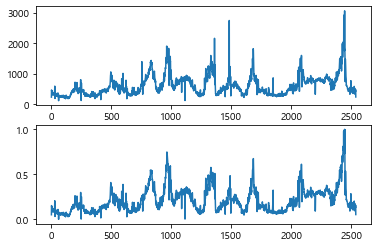

In [62]:
view_original_price_graph(4)

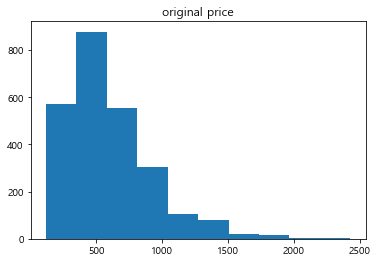

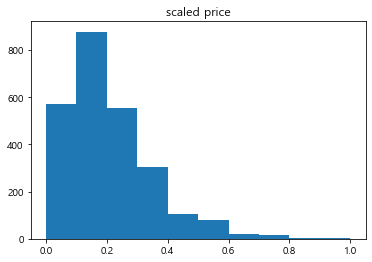

<Figure size 432x288 with 0 Axes>

In [69]:
view_original_price_hist(4)

In [85]:
input_data_list[4]

,Unnamed: 0,날짜,평균강수량,최대강수량,평균기온,최고기온,최저기온,평균습도,최저습도,평균풍속,...,보통휘발유,자동차용경유,소비자물가지수,농축수산물,공업제품,집세,공공서비스,개인서비스,근원물가,생활물가
0,0,2014-01-02,0.0,0.0,2.6,9.1,-2.2,49,10,1.6,...,1887.56,1706.27,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6
1,1,2014-01-03,0.0,0.0,2.6,10.1,-3.2,54,12,1.2,...,1888.51,1707.15,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6
2,2,2014-01-04,1.2,31.0,1.5,6.9,-2.8,63,12,1.7,...,1888.98,1707.61,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6
3,3,2014-01-05,0.1,30.2,0.7,6.6,-3.7,62,9,1.6,...,1889.11,1707.56,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6
4,4,2014-01-06,0.0,11.0,0.2,7.6,-5.1,59,12,1.1,...,1889.14,1707.80,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,2534,2020-12-27,2.1,53.2,3.2,8.1,-1.0,77,18,1.0,...,1406.84,1207.54,0.5,9.7,-0.9,0.7,-2.0,1.3,0.9,-0.1
2535,2535,2020-12-28,0.1,1.4,4.2,11.9,-0.4,80,22,0.9,...,1409.68,1210.65,0.5,9.7,-0.9,0.7,-2.0,1.3,0.9,-0.1
2536,2536,2020-12-29,1.8,6.9,2.1,8.6,-2.3,81,31,1.8,...,1413.82,1214.60,0.5,9.7,-0.9,0.7,-2.0,1.3,0.9,-0.1
2537,2537,2020-12-30,1.1,33.4,-6.8,-1.1,-9.7,56,17,4.0,...,1417.11,1218.04,0.5,9.7,-0.9,0.7,-2.0,1.3,0.9,-0.1


# Train/Test Split 

In [72]:
#train_X, test_X, train_y, test_y = get_data_split(input_data_list[0], X_column_list[0], y_column_list[0])
train_X, test_X, train_y, test_y = make_dataset_split(input_data_list[4], X_column_list[4], y_column_list[4], 7)

#true_y = test_y.to_numpy()
#true_y = np.ravel(true_y)

feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액', '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가'] 
label :  ['배추가격']
(2025, 7, 26) (2025, 1) (507, 7, 26) (507, 1)


In [99]:
train_feature, train_X, test_X, valid_X, train_y, test_y, valid_y = preprocessing(input_data_list[4], 7, path)

train :  2031 test :  508
scale_cols :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '배추가격', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액', '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가']
feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '배추가격', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액', '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가'] 
label :  ['생활물가']
(1619, 7, 27) (405, 7, 27) (501, 7, 27) (1619, 1) (405, 1) (501, 1)


# Modleing/Training
1. model_xgb : 사이킷런 래퍼 클래스, 파이썬 래퍼 클래스 -> 사이킷런 기반 Estimator 상속 받아 작성, 사이킷런 래퍼 클래스로 구현 
2. model_lgbm 
3. model_rnn

In [24]:
# hyper parameter
params = { 
    'max_depth':3,
    'eta':0.1,
    'objective':'reg:linear',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds = 400 
evals = [(test_X, test_y)]

#gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7

In [101]:
#model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.001, colsample_bytree=0.5, subsample=0.8)
model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05)
get_cv_score(model_xgb, train_X, train_y)

model_xgb.fit(train_X, train_y, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals,verbose=True)
pred_xgb = model_xgb.predict(test_X)

5 교차 검증의 개별 Negative MSE scores:  [nan nan nan nan nan]
5 교차 검증의 개별 RMSE scores:  [nan nan nan nan nan]
5 교차 검증의 평균 RMSE scores: nan


C:\Users\mtang\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mtang\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mtang\anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\mtang\anaconda3\lib\site-packages\xgboost\sklearn.py", line 761, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\Users\mtang\anaconda3\lib\site-packages\xgboost\sklearn.py", line 286, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "C:\Users\mtang\anaconda3\lib\site-packages\xgboost\sklearn.py", line 775, in <lambda>
    create_dmatrix=lambda **kwargs: DMatrix(nthread=self.n_jobs, **kwargs),
  Fil

ValueError: Please reshape the input data into 2-dimensional matrix.

In [42]:
#model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.001, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.05)
get_cv_score(model_lgbm, train_X, train_y)

model_lgbm.fit(train_X, train_y, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals,verbose=True)
pred_lgbm = model_lgbm.predict(test_X)

5 교차 검증의 개별 Negative MSE scores:  [-0.0034 -0.0044 -0.0048 -0.003  -0.0029]
5 교차 검증의 개별 RMSE scores:  [0.0583 0.0665 0.0696 0.0552 0.0541]
5 교차 검증의 평균 RMSE scores: 0.061
[1]	valid_0's l2: 0.00888611
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.00849508
[3]	valid_0's l2: 0.00814959
[4]	valid_0's l2: 0.00784216
[5]	valid_0's l2: 0.00754614
[6]	valid_0's l2: 0.00729274
[7]	valid_0's l2: 0.00705827
[8]	valid_0's l2: 0.00685426
[9]	valid_0's l2: 0.00666156
[10]	valid_0's l2: 0.00648778
[11]	valid_0's l2: 0.00634714
[12]	valid_0's l2: 0.00620303
[13]	valid_0's l2: 0.00607278
[14]	valid_0's l2: 0.00596393
[15]	valid_0's l2: 0.00586695
[16]	valid_0's l2: 0.00578796
[17]	valid_0's l2: 0.00570561
[18]	valid_0's l2: 0.00563282
[19]	valid_0's l2: 0.00557692
[20]	valid_0's l2: 0.005512
[21]	valid_0's l2: 0.00544751
[22]	valid_0's l2: 0.00540689
[23]	valid_0's l2: 0.00535431
[24]	valid_0's l2: 0.00532775
[25]	valid_0's l2: 0.00530199
[26]	valid_0's l2: 0.00526027

# 평가 지표 및 해석

In [27]:
print("########## xgb  ##########")
show_mse_rmse(test_y, pred_xgb)

print("########## lgbm ##########")
show_mse_rmse(test_y, pred_lgbm)

########## xgb  ##########
mse : 0.004180
rmse: 0.064651 

########## lgbm ##########
mse : 0.004647
rmse: 0.068171 



In [28]:
show_pred(test_y, pred_xgb)

,true_y,prediction
0,0.048745,0.118877
1,0.067081,0.179717
2,0.350312,0.310867
3,0.172878,0.165907
4,0.189255,0.173246
...,...,...
438,0.104885,0.145399
439,0.202769,0.148026
440,0.059322,0.099716
441,0.119491,0.089948


In [29]:
show_pred(test_y, pred_lgbm)

,true_y,prediction
0,0.048745,0.119251
1,0.067081,0.151217
2,0.350312,0.290654
3,0.172878,0.161487
4,0.189255,0.180279
...,...,...
438,0.104885,0.129015
439,0.202769,0.149361
440,0.059322,0.110746
441,0.119491,0.097897


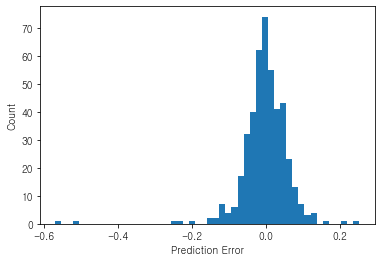

In [30]:
show_prediction_error(test_y, pred_xgb)

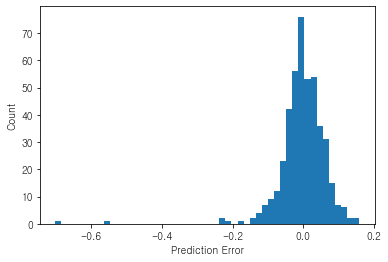

In [31]:
show_prediction_error(test_y, pred_lgbm)

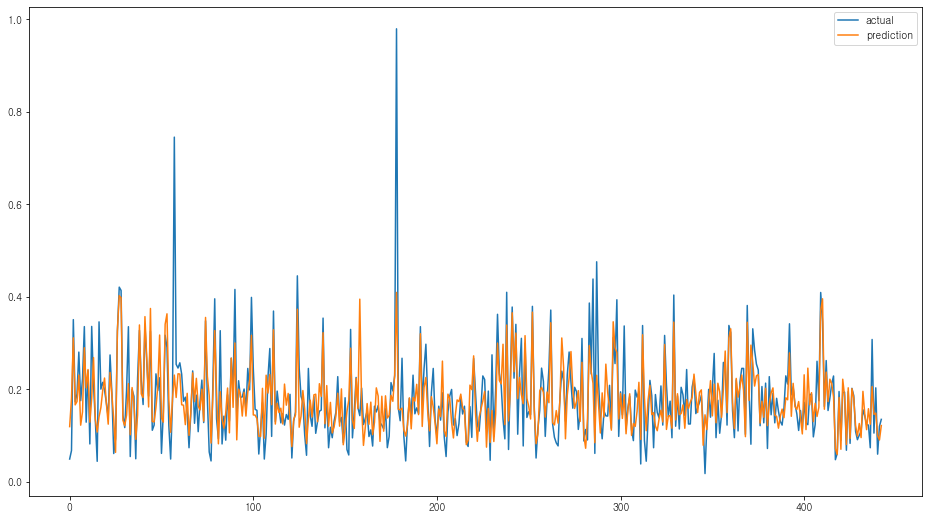

In [43]:
graph(pred_xgb, true_y)

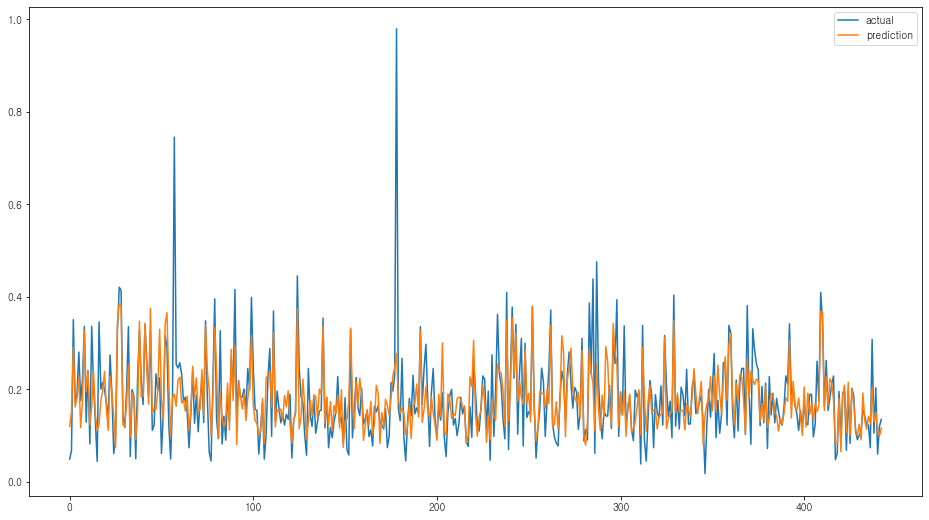

In [44]:
graph(pred_lgbm, true_y)

<AxesSubplot:>

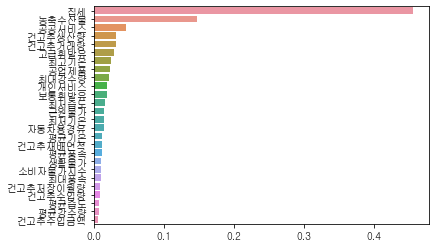

In [34]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

<AxesSubplot:>

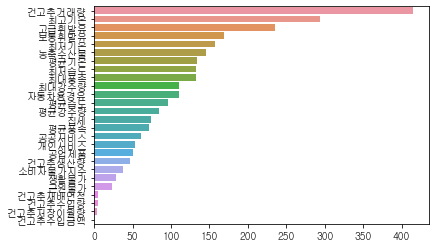

In [35]:
# 회귀 트리 Regressor 클래스는 선형 호귀와 다른 처리 방식이므로 회귀 계수를 제공하는 coef_ 속성이 없다. 
# 대신 feature_importances_를 이용해 피처별 중요도를 알 수 있다. 

feature_series = pd.Series(data=model_lgbm.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

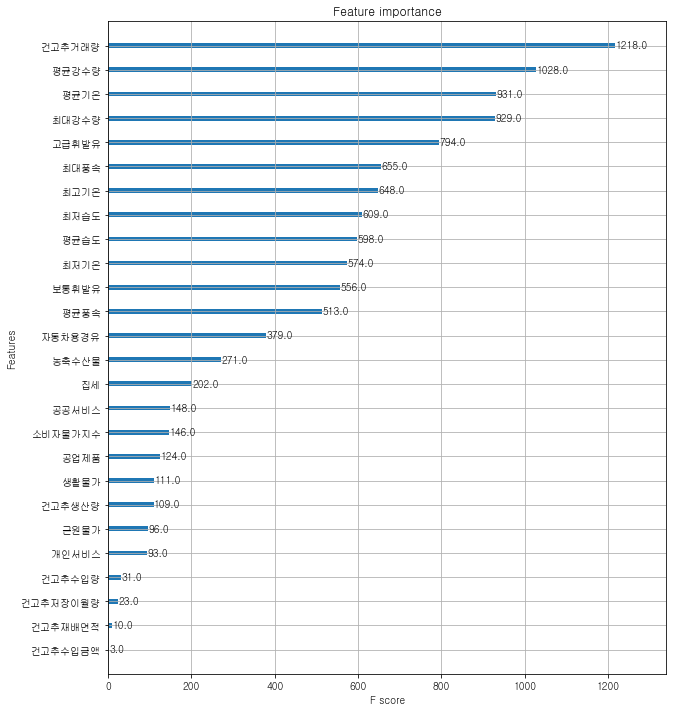

In [36]:
feature_importance(model_xgb)